In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('output.csv')

In [3]:
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)

In [4]:
dataset.drop(columns='Unnamed: 0', inplace=True)

In [5]:
dataset = dataset.join(pd.get_dummies(dataset['Zona']))

In [6]:
dataset = dataset.join(pd.get_dummies(dataset['Floor']))

In [7]:
dataset.drop(columns='Zona', inplace=True)
dataset.drop(columns='Floor', inplace=True)

In [8]:
dataset['Price'] = dataset['Price'].str.extract('(\d+)', expand=False)

In [9]:
dataset.fillna(0, inplace=True)
dataset['Price'] = dataset['Price'].astype(int)
dataset['Rooms'] = dataset['Rooms'].astype(int)
dataset['Bathrooms'] = dataset['Bathrooms'].astype(int)

In [10]:
dataset = dataset[(dataset['Price']<= 1100) & (dataset['Price'] > 0)]

In [11]:
obbiettivo = dataset['Price']
dati = dataset.drop(columns= 'Price')

In [12]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dati.values, obbiettivo.values,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=50, population_size=20, verbosity=2, max_eval_time_mins=2, n_jobs=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_torino_pipeline.py')

Generation 1 - Current best internal CV score: -18606.84983765147
Generation 2 - Current best internal CV score: -18606.84983765147
Generation 3 - Current best internal CV score: -18306.616094031764
Generation 4 - Current best internal CV score: -18306.616094031764
Generation 5 - Current best internal CV score: -18306.616094031764
Generation 6 - Current best internal CV score: -18306.616094031764
Generation 7 - Current best internal CV score: -18306.616094031764
Generation 8 - Current best internal CV score: -18271.908906170116
Generation 9 - Current best internal CV score: -18244.23799919248
Generation 10 - Current best internal CV score: -18244.23799919248
Generation 11 - Current best internal CV score: -18210.0779375717
Generation 12 - Current best internal CV score: -18210.0779375717
Generation 13 - Current best internal CV score: -18210.0779375717
Generation 14 - Current best internal CV score: -18210.0779375717
Generation 15 - Current best internal CV score: -18199.20484884784
Ge

/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [13]:
dataset.to_csv('dataset.csv')

In [68]:
casa = [[2,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]

In [69]:
tpot.predict(casa)

/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([326.1519085])

In [16]:
import matplotlib.pyplot as plot

In [23]:
predictions = []
for item in X_test:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_trought = y_test

/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.p

In [24]:
confronto = pd.DataFrame()
confronto['test'] = ground_trought
confronto['predictions'] = flat_list

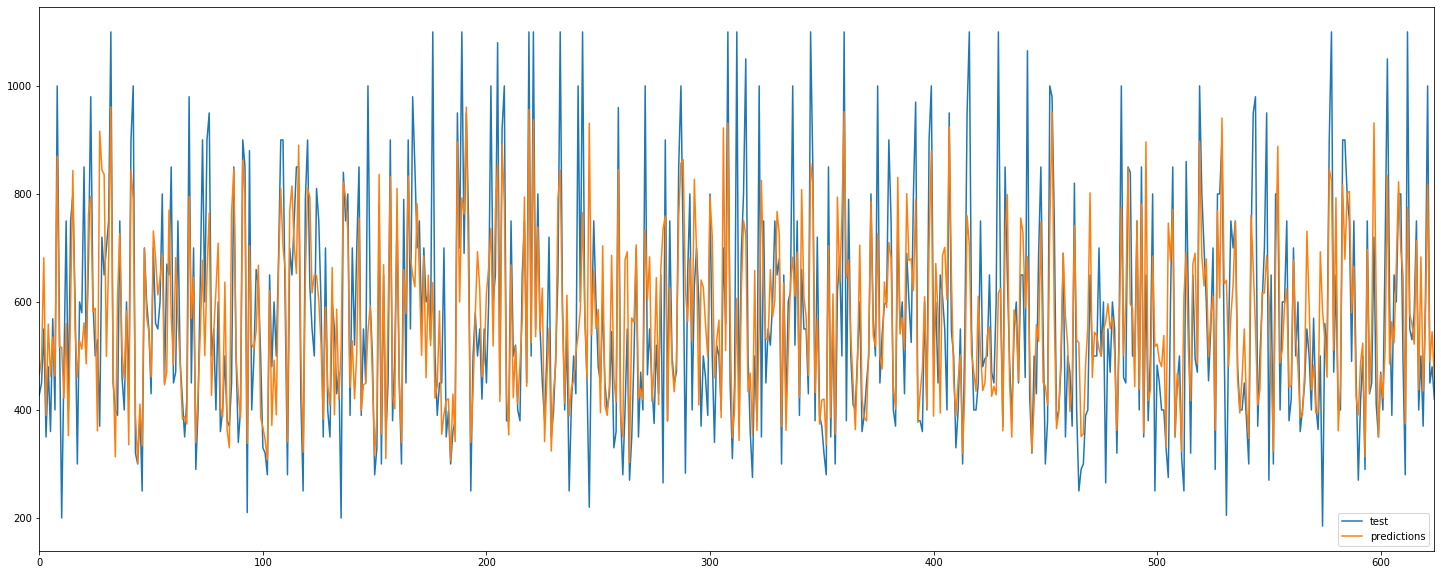

In [34]:
plt = confronto.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato.png")
fig.savefig("risultato.svg")

In [26]:
from scipy.stats.stats import pearsonr

pearsonr(confronto['test'].values, confronto['predictions'].values)

(0.7509895375159817, 2.1525799910591288e-114)

In [27]:
diff = confronto['test']-confronto['predictions']

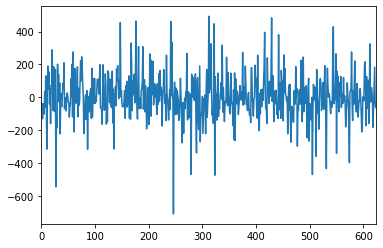

In [28]:
diff.plot()

In [50]:
import pickle

with open('tpot_.pickle','wb') as xx:
    pickle.dump(tpot.fitted_pipeline_,xx)

In [53]:
with open('tpot_.pickle', 'rb') as xx:
    model = pickle.load(xx)

model.predict(casa)

/home/wonka/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([326.1519085])

In [29]:
my_dict = list(tpot.evaluated_individuals_.items())

model_scores = pd.DataFrame()
for model in my_dict:
    model_name = model[0]
    model_info = model[1]
    cv_score = model[1].get('internal_cv_score')  # Pull out cv_score as a column (i.e., sortable)
    model_scores = model_scores.append({'model': model_name,
                                        'cv_score': cv_score,
                                        'model_info': model_info,},
                                       ignore_index=True)

model_scores = model_scores.sort_values('cv_score', ascending=False)

In [55]:
model_scores

,cv_score,model,model_info
393,-1.793047e+04,ExtraTreesRegressor(LassoLarsCV(PolynomialFeat...,"{'generation': 'INVALID', 'mutation_count': 9,..."
452,-1.793095e+04,ExtraTreesRegressor(LassoLarsCV(PolynomialFeat...,"{'generation': 'INVALID', 'mutation_count': 9,..."
336,-1.793194e+04,ExtraTreesRegressor(LassoLarsCV(PolynomialFeat...,"{'generation': 'INVALID', 'mutation_count': 8,..."
330,-1.801339e+04,ExtraTreesRegressor(RidgeCV(OneHotEncoder(Comb...,"{'generation': 'INVALID', 'mutation_count': 5,..."
454,-1.801339e+04,ExtraTreesRegressor(RidgeCV(OneHotEncoder(Comb...,"{'generation': 'INVALID', 'mutation_count': 6,..."
463,-1.804144e+04,ExtraTreesRegressor(LassoLarsCV(PolynomialFeat...,"{'generation': 'INVALID', 'mutation_count': 11..."
468,-1.808325e+04,ExtraTreesRegressor(RidgeCV(OneHotEncoder(Lass...,"{'generation': 'INVALID', 'mutation_count': 6,..."
409,-1.812253e+04,ExtraTreesRegressor(LassoLarsCV(CombineDFs(Fea...,"{'generation': 'INVALID', 'mutation_count': 12..."
435,-1.812253e+04,ExtraTreesRegressor(LassoLarsCV(CombineDFs(Fea...,"{'generation': 'INVALID', 'mutation_count': 17..."
441,-1.812874e+04,ExtraTreesRegressor(LassoLarsCV(PolynomialFeat...,"{'generation': 'INVALID', 'mutation_count': 10..."


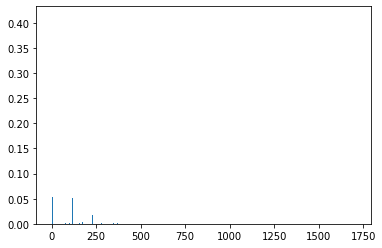

In [73]:
exctracted_best_model = tpot.fitted_pipeline_.steps[-1][1]
exctracted_best_model.feature_importances_
positions= range(exctracted_best_model.feature_importances_.shape[0])
plot.bar(positions, exctracted_best_model.feature_importances_)
plot.show()

In [75]:
exctracted_best_model.feature_importances_

array([4.12219795e-01, 1.08003902e-03, 1.00589216e-03, ...,
       0.00000000e+00, 0.00000000e+00, 4.42760779e-06])